In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math

In [13]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
df=pd.read_csv('C:/Users/91866/Desktop/TENSOR/air-quality-india.csv')

In [4]:
df

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50
...,...,...,...,...,...,...
36187,2022-06-04 11:00:00,2022,6,4,11,35.89
36188,2022-06-04 12:00:00,2022,6,4,12,33.83
36189,2022-06-04 13:00:00,2022,6,4,13,33.05
36190,2022-06-04 14:00:00,2022,6,4,14,35.29


# Exploratory data analysis

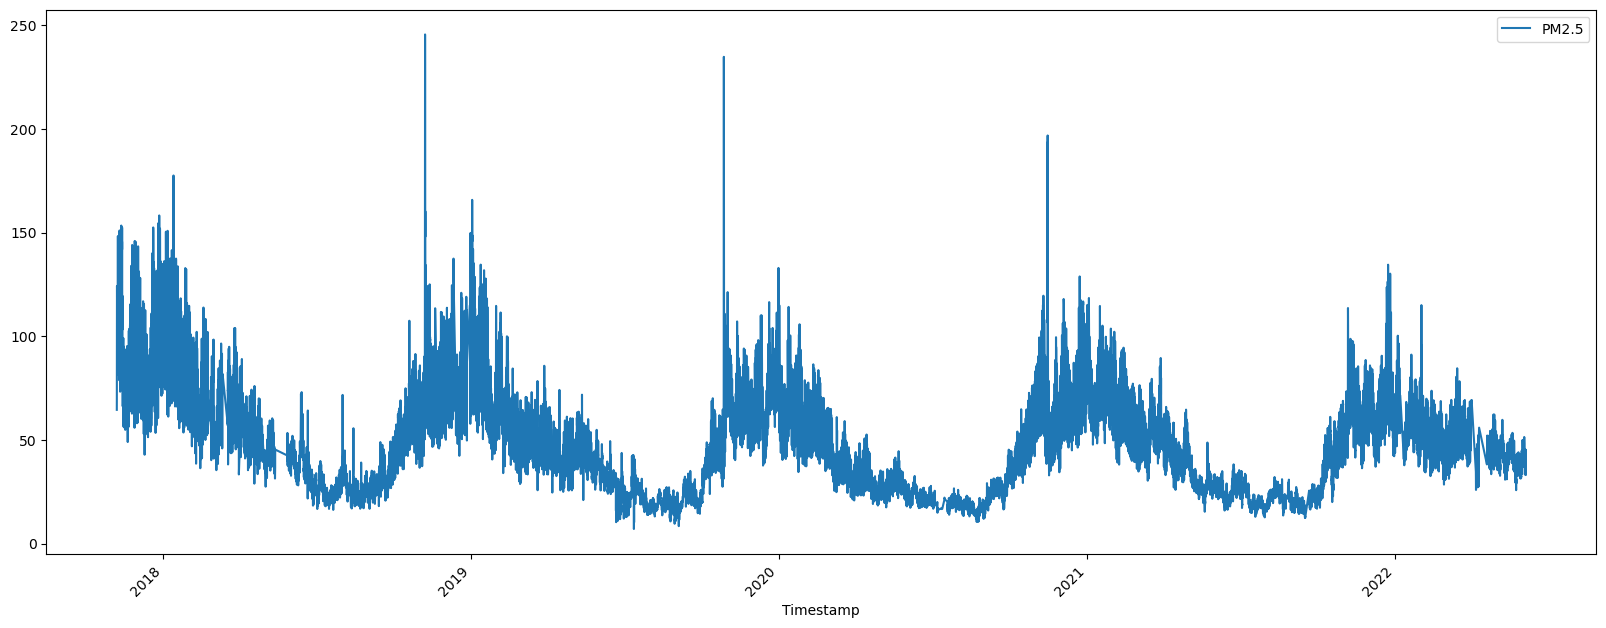

In [10]:
df.plot(x='Timestamp',y='PM2.5',figsize=(20,8))
plt.xticks(rotation=45)

plt.show()

<AxesSubplot:xlabel='Year'>

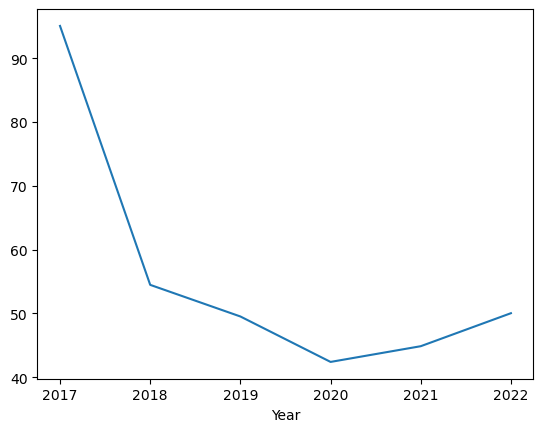

In [11]:
df.groupby('Year')['PM2.5'].mean().plot()

<AxesSubplot:xlabel='Month', ylabel='PM2.5'>

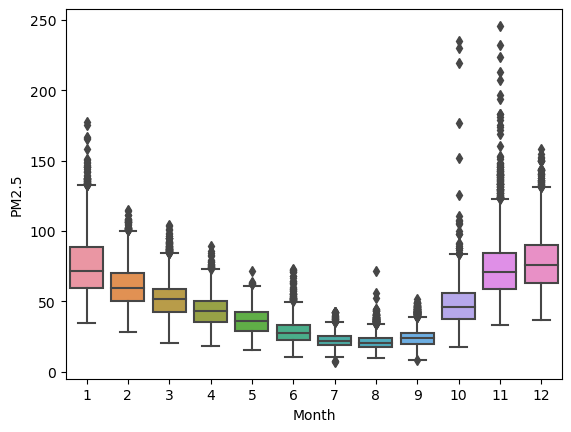

In [12]:
df_month=df.loc[:,['Month','PM2.5']]
sns.boxplot(x='Month', y='PM2.5',data=df_month)

<AxesSubplot:xlabel='Day'>

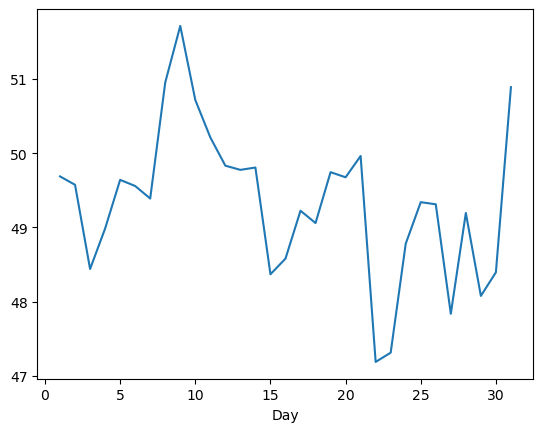

In [32]:
df.groupby('Day')['PM2.5'].mean().plot()

In [16]:
df_date=pd.DataFrame(df.groupby('Date')['PM2.5'].mean())
df_date

,PM2.5
Date,
2017-11-07,99.805833
2017-11-08,110.979565
2017-11-09,114.915833
2017-11-10,119.404091
2017-11-11,109.267273
...,...
2022-05-31,41.465417
2022-06-01,41.645833
2022-06-02,42.255417


# Modelling

In [17]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1293

In [18]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.80924161],
       [0.91297267],
       [0.94951492],
       ...,
       [0.27497376],
       [0.24870153],
       [0.24014526]])

In [20]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

In [21]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1233, 60, 1)

In [22]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [23]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [24]:
model.fit(x_train,y_train, batch_size=1, epochs=5)

Epoch 1/5
1233/1233 [==============================] - 39s 26ms/step - loss: 0.0067
Epoch 2/5
1233/1233 [==============================] - 33s 27ms/step - loss: 0.0034
Epoch 3/5
1233/1233 [==============================] - 32s 26ms/step - loss: 0.0032
Epoch 4/5
1233/1233 [==============================] - 34s 28ms/step - loss: 0.0030
Epoch 5/5
1233/1233 [==============================] - 33s 27ms/step - loss: 0.0030


# Predcition

In [25]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [26]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

11/11 [==============================] - 4s 19ms/step


In [28]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.986227702138685

In [29]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

C:\Users\91866\AppData\Local\Temp\ipykernel_10784\1077779411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


,PM2.5,Predictions
Date,,
2021-06-28,28.667917,26.273970
2021-06-29,30.903750,29.579008
2021-06-30,29.017917,30.865271
2021-07-01,27.166667,29.316853
2021-07-02,27.132917,28.194384
...,...,...
2022-05-31,41.465417,36.851357
2022-06-01,41.645833,40.003231
2022-06-02,42.255417,39.630146


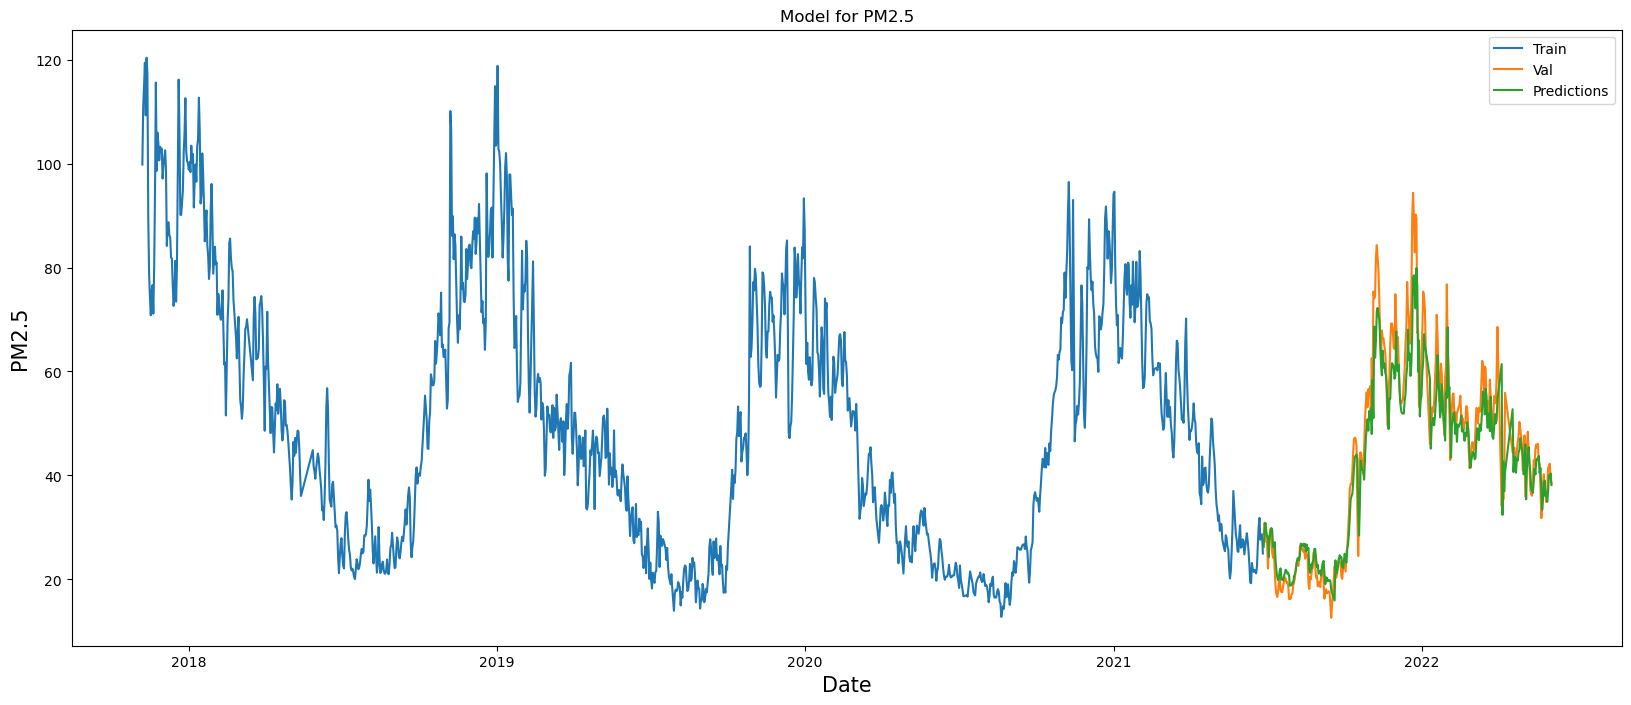

In [30]:
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("PM2.5",fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid['PM2.5'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])